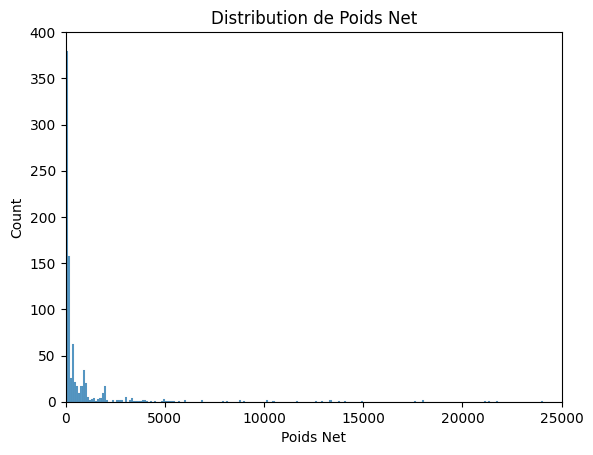

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import configparser
import seaborn as sns
import shap
import sqlite3


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

config = configparser.ConfigParser()
config.read('config.config')
fichier = config['Settings']['fichier']
ligne_debut = int(config['Settings']['ligne_debut'])
seed = int(config['Settings']['SEED'])
### Définir la seed
np.random.seed(seed)
### Charger le fichier
data = pd.read_excel(fichier, skiprows=ligne_debut)
data = data.sample(n=1000, random_state=seed)
### Supprimer les colonnes de quantité et CA
data = data.drop(['Qté facturée (Base Unit)','CA Net'], axis = 1)
### Changer le type de données dans certaines colonnes
data['Poids Net'] = pd.to_numeric(data['Poids Net'], errors='coerce')
data['Donneur d\'ordre'] = data['Donneur d\'ordre'].astype(str)
### Retirer les poids négatifs ou nuls
data = data.loc[data['Poids Net'] >0]
# Vérifier que le minimum de la colonne est supérieur ou égal à zéro
assert (data[['Poids Net']] > 0).all().all(), "Il y a des valeurs négatives dans les données d'origine"
### Retirer les articles finissant par -999 ou -998
data = data[~data['Article'].str.endswith(('-999', '-998'))]
# Vérifier qu'il ne reste pas d'articles finissant par -999 ou -998
assert (~data['Article'].str.endswith(('-999', '-998'))).all(), "Il reste des articles finissant par -999 ou -998"
### Retirer les données pour un donneur d'ordre qui commence par EPREST
data = data[~data['Article'].str.startswith(('EPREST'))]
# Vérifier qu'il ne reste pas d'articles commençant par EPREST
assert (~data['Article'].str.startswith(('EPREST'))).all(), "Il reste des articles commençant par EPREST"
### Transformer les données
data = pd.get_dummies(data, columns=['Donneur d\'ordre','Article','Mois/Année de facturation'])

sns.histplot(data['Poids Net'])
plt.title(f'Distribution de Poids Net')
plt.xlim(0,25000)
plt.ylim(0,500)
plt.show()

RMSE du meilleur modèle Lasso : 7655.77
Meilleur paramètre alpha pour Lasso : 100.0
Poids Net    70500.0
dtype: float64


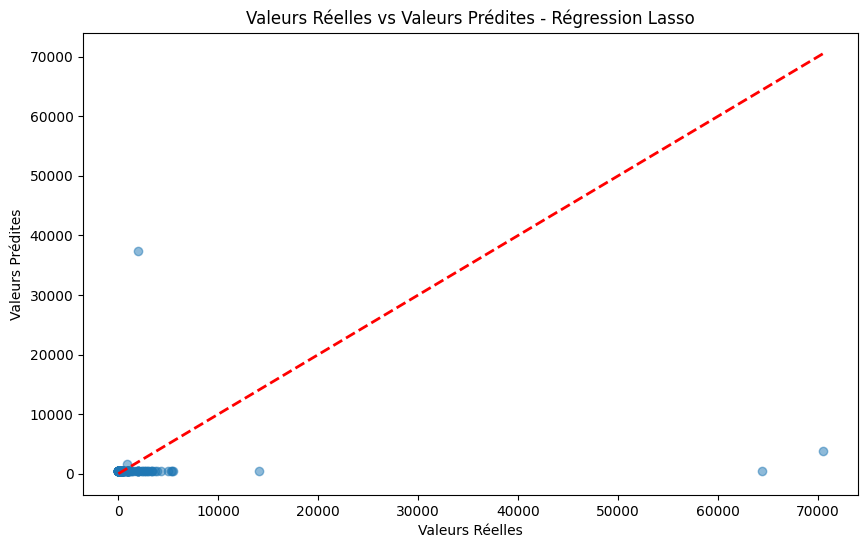

In [5]:
X = data.drop(['Poids Net'], axis = 1)
y = data[['Poids Net']]

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Division des données normalisées en ensembles d'entraînement et de test
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Définir la grille des valeurs pour l'hyperparamètre alpha pour Lasso
alpha_values_lasso_narrow = {'alpha': [10.0, 50.0, 100.0, 200.0]}

# Configurer la recherche de grille pour Lasso avec des paramètres optimisés
lasso = Lasso(max_iter=20000)  # Augmenter le nombre d'itérations
grid_search_lasso_narrow = GridSearchCV(lasso, alpha_values_lasso_narrow, scoring='neg_mean_squared_error', cv=3)

# Exécuter la recherche de grille pour Lasso
grid_search_lasso_narrow.fit(X_train_scaled, y_train)

# Meilleur modèle Lasso avec des paramètres optimisés
best_lasso_model_narrow = grid_search_lasso_narrow.best_estimator_

# Prédiction sur l'ensemble de test avec le meilleur modèle Lasso optimisé
y_pred_best_lasso_narrow = best_lasso_model_narrow.predict(X_test_scaled)

# Calcul de l'erreur quadratique moyenne pour Lasso optimisé
mse_best_lasso_narrow = mean_squared_error(y_test, y_pred_best_lasso_narrow)
rmse_best_lasso_narrow = mse_best_lasso_narrow ** 0.5

# Afficher les résultats
print(f"RMSE du meilleur modèle Lasso : {rmse_best_lasso_narrow:.2f}")
print(f"Meilleur paramètre alpha pour Lasso : {grid_search_lasso_narrow.best_params_['alpha']}")
print(y_test.max())

# Visualiser les résultats prédits pour Lasso
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_lasso_narrow, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', lw=2, color='red')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites')
plt.title('Valeurs Réelles vs Valeurs Prédites - Régression Lasso')
plt.show()


RMSE du meilleur modèle Lasso filtré : 7394.23
Meilleur paramètre alpha pour Lasso filtré : 100.0


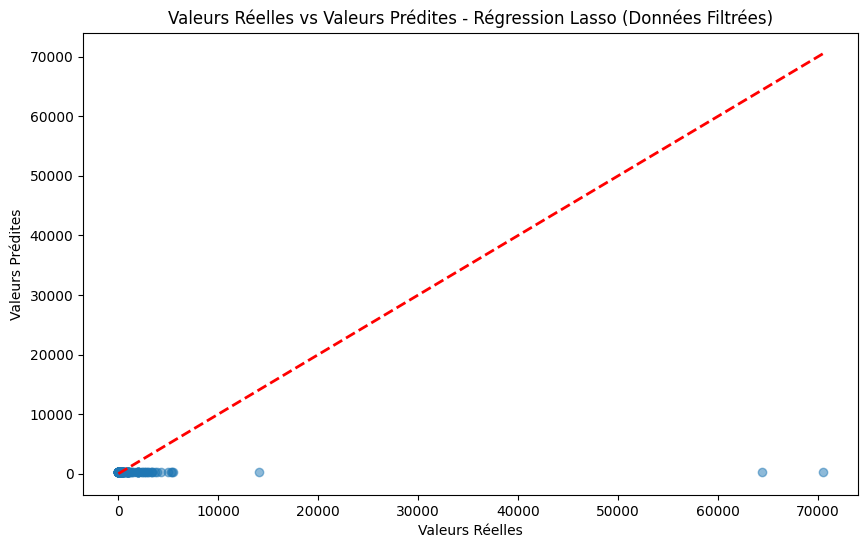

In [6]:
# Calculer les statistiques de base
q1 = np.percentile(y_train, 25)
q3 = np.percentile(y_train, 75)
iqr = q3 - q1

# Définir les limites pour les valeurs aberrantes
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Identifier les valeurs aberrantes
outliers = np.where((y_train < lower_bound) | (y_train > upper_bound))

# Éliminer les valeurs aberrantes des données d'entraînement
X_train_filtered = np.delete(X_train_scaled, outliers, axis=0)
y_train_filtered = np.delete(y_train, outliers, axis=0)

# Réentraîner le modèle Lasso avec les données filtrées
lasso_filtered = Lasso(max_iter=20000)
grid_search_lasso_filtered = GridSearchCV(lasso_filtered, alpha_values_lasso_narrow, scoring='neg_mean_squared_error', cv=3)
grid_search_lasso_filtered.fit(X_train_filtered, y_train_filtered)

# Meilleur modèle Lasso avec les données filtrées
best_lasso_model_filtered = grid_search_lasso_filtered.best_estimator_

# Prédiction sur l'ensemble de test avec le meilleur modèle Lasso filtré
y_pred_best_lasso_filtered = best_lasso_model_filtered.predict(X_test_scaled)

# Calcul de l'erreur quadratique moyenne pour Lasso filtré
mse_best_lasso_filtered = mean_squared_error(y_test, y_pred_best_lasso_filtered)
rmse_best_lasso_filtered = mse_best_lasso_filtered ** 0.5

# Afficher les résultats
print(f"RMSE du meilleur modèle Lasso filtré : {rmse_best_lasso_filtered:.2f}")
print(f"Meilleur paramètre alpha pour Lasso filtré : {grid_search_lasso_filtered.best_params_['alpha']}")

# Visualiser les résultats prédits pour Lasso filtré
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_lasso_filtered, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', lw=2, color='red')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites')
plt.title('Valeurs Réelles vs Valeurs Prédites - Régression Lasso (Données Filtrées)')
plt.show()